In [1]:
"""
intro_pyro.py

Intro to probabilistic programming with Pyro
Target audience: Scientists without prior knowledge in probabilistic programming

Content:
  1. Random variables & distributions (PyTorch / Pyro)
  2. First Pyro model: coin flipping with NUTS
  3. Bayesian "sensor" network with analytic expressions
  4. Bayesian linear regression as a graphical model
  5. MAP-like point estimation via SVI
"""


import math
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.distributions import Normal, Beta, Bernoulli

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

# Fix RNG seeds for reproducibility
pyro.set_rng_seed(42)
torch.manual_seed(42)


c:\Users\c.findenig\AppData\Local\anaconda3\envs\pyro\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
############################################################
# 1. RANDOM VARIABLES AND DISTRIBUTIONS
############################################################

print("\n=== Section 1: Random variables & distributions ===")

# PyTorch distributions (can also use pyro.distributions.* which wraps them)
mu = 0.0
sigma = 1.0
x_dist = Normal(loc=torch.tensor(mu), scale=torch.tensor(sigma))

print("Mean of x_dist =", x_dist.mean.item())
print("Var  of x_dist =", x_dist.variance.item())

# Draw samples
xs = x_dist.sample(sample_shape=(5,))
print("Five samples from Normal(0,1):", xs.tolist())

# Beta distribution for probabilities
alpha, beta = 2.0, 2.0
p_dist = Beta(concentration1=torch.tensor(alpha),
              concentration0=torch.tensor(beta))
ps = p_dist.sample(sample_shape=(5,))
print("Five samples from Beta(2,2):", ps.tolist())



=== Section 1: Random variables & distributions ===
Mean of x_dist = 0.0
Var  of x_dist = 1.0
Five samples from Normal(0,1): [0.33669036626815796, 0.12880940735340118, 0.23446236550807953, 0.23033303022384644, -1.1228563785552979]
Five samples from Beta(2,2): [0.3950178027153015, 0.7608731985092163, 0.7622777819633484, 0.5179688334465027, 0.5465466380119324]


In [8]:
# Hook function
def print_hook(kernel, samples, stage, i):
    """
    kernel  : the MCMC kernel (e.g. NUTS)
    samples : dict of current latent samples
    stage   : "warmup" or "sample"
    i       : iteration number (0-based)
    """
    if i % 50 == 0:
        print(f"[{stage}] Iteration {i}")
        for name, value in samples.items():
            print(f"  {name} = {value}")


=== Section 2: A first Pyro model (coin flipping) ===
True p = 0.7
Number of observations = 50
Number of heads in data = 34
Running NUTS on coinflip model ...
[Warmup] Iteration 0
  p = 1.441969633102417
[Warmup] Iteration 50
  p = 0.844717264175415
[Sample] Iteration 0
  p = 0.5372681617736816
[Sample] Iteration 50
  p = -0.11974835395812988
[Sample] Iteration 100
  p = 0.3991747498512268
[Sample] Iteration 150
  p = 0.7405633330345154

                mean       std    median      2.5%     97.5%     n_eff     r_hat
         p      0.65      0.06      0.65      0.54      0.77     85.91      1.00

Number of divergences: 0
Posterior mean of p ≈ 0.65366656


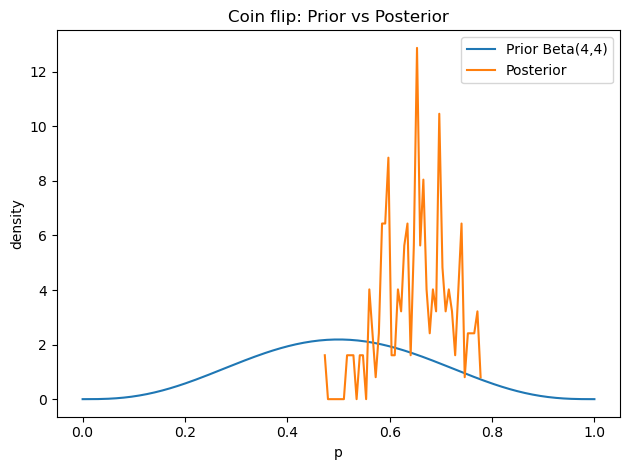

In [9]:

############################################################
# 2. FIRST PYRO MODEL: COIN FLIP
############################################################

print("\n=== Section 2: A first Pyro model (coin flipping) ===")

# Model:
#   p ~ Beta(4,4)
#   y[i] ~ Bernoulli(p)


def coinflip_model(y_obs=None):
    p = pyro.sample("p", dist.Beta(4.0, 4.0))
    with pyro.plate("data", len(y_obs) if y_obs is not None else 1):
        pyro.sample("y", dist.Bernoulli(p), obs=y_obs)
    return p


# Generate synthetic data
p_true = 0.7
N = 50
y_data = dist.Bernoulli(torch.tensor(p_true)).sample(sample_shape=(N,))
print("True p =", p_true)
print("Number of observations =", N)
print("Number of heads in data =", int(y_data.sum().item()))

# NUTS MCMC
nuts_kernel = NUTS(coinflip_model)
mcmc = MCMC(nuts_kernel, num_chains=1, num_samples=200, warmup_steps=100, disable_progbar=True, hook_fn=print_hook)
print("Running NUTS on coinflip model ...")
mcmc.run(y_obs=y_data)
mcmc.summary(prob=0.95)

posterior_samples = mcmc.get_samples()
p_samples = posterior_samples["p"].detach().cpu().numpy()
print("Posterior mean of p ≈", p_samples.mean())

# Plot prior vs posterior for p
p_range = torch.linspace(0.0, 1.0, 200)
prior_vals = dist.Beta(4.0, 4.0).log_prob(p_range).exp().numpy()

plt.figure()
plt.plot(p_range.numpy(), prior_vals, label="Prior Beta(4,4)")

# Simple density estimate for posterior
hist_y, hist_x = torch.histogram(torch.tensor(p_samples), bins=50, density=True)
hist_x_mid = 0.5 * (hist_x[:-1] + hist_x[1:])

plt.plot(hist_x_mid.numpy(), hist_y.numpy(), label="Posterior")
plt.xlabel("p")
plt.ylabel("density")
plt.title("Coin flip: Prior vs Posterior")
plt.legend()
plt.tight_layout()


In [4]:
mcmc.summary(prob=0.95)



                mean       std    median      2.5%     97.5%     n_eff     r_hat
         p      0.69      0.07      0.70      0.57      0.82     65.89      1.01

Number of divergences: 0



=== Section 4: Bayesian linear regression as a graphical model ===
True a = 2.5 , b = -1.0 , σ = 0.5
Running NUTS on linear_regression model ...
[Warmup] Iteration 0
  a = -1.486045479774475
  b = -1.685307264328003
  sigma = 0.037473440170288086
[Warmup] Iteration 50
  a = 2.7332515716552734
  b = -1.1729768514633179
  sigma = -0.8077280521392822
[Warmup] Iteration 100
  a = 2.68040132522583
  b = -1.103654146194458
  sigma = -0.5827828049659729
[Warmup] Iteration 150
  a = 2.7325708866119385
  b = -1.2793391942977905
  sigma = -0.7086588144302368
[Sample] Iteration 0
  a = 2.7662646770477295
  b = -1.1682993173599243
  sigma = -0.6101095676422119
[Sample] Iteration 50
  a = 2.6378896236419678
  b = -1.1699179410934448
  sigma = -0.653167188167572
[Sample] Iteration 100
  a = 2.7608232498168945
  b = -1.2661758661270142
  sigma = -0.8151848912239075
[Sample] Iteration 150
  a = 2.7854347229003906
  b = -1.2712979316711426
  sigma = -0.7163653373718262
(200,)
Posterior mean a ≈ 2.6953

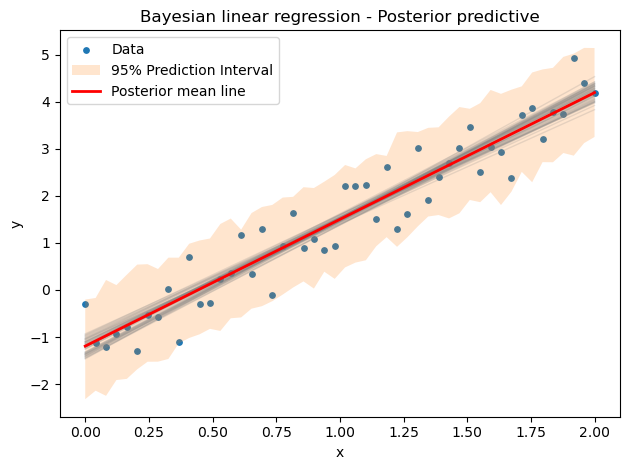

In [11]:
############################################################
# 4. BAYESIAN LINEAR REGRESSION AS A GRAPHICAL MODEL
############################################################

print("\n=== Section 4: Bayesian linear regression as a graphical model ===")

# Model:
#   y = a * x + b + ε, ε ~ Normal(0, σ)
# Priors:
#   a ~ Normal(0, 10)
#   b ~ Normal(0, 10)
#   σ ~ HalfCauchy(3) (implemented via truncated Cauchy proxy)


def linear_regression_model(x, y_obs=None):
    a = pyro.sample("a", dist.Normal(0.0, 10.0))
    b = pyro.sample("b", dist.Normal(0.0, 10.0))
    # Positive noise scale; use LogNormal as a simple choice.
    sigma = pyro.sample("sigma", dist.LogNormal(0.0, 1.0))

    mean = a * x + b
    with pyro.plate("data", len(x)):
        pyro.sample("y", dist.Normal(mean, sigma), obs=y_obs)


# Generate synthetic data
a_true = 2.5
b_true = -1.0
sigma_true = 0.5
N_lr = 50

x_lr = torch.linspace(0.0, 2.0, N_lr)
y_lr = a_true * x_lr + b_true + dist.Normal(0.0, sigma_true).sample(sample_shape=(N_lr,))

print("True a =", a_true, ", b =", b_true, ", σ =", sigma_true)

# NUTS inference
nuts_lr = NUTS(linear_regression_model)
mcmc_lr = MCMC(nuts_lr, num_chains=1, num_samples=200, warmup_steps=200, disable_progbar=True, hook_fn=print_hook)
print("Running NUTS on linear_regression model ...")
mcmc_lr.run(x_lr, y_lr)

lr_samples = mcmc_lr.get_samples()
a_post = lr_samples["a"].detach().cpu().numpy()
b_post = lr_samples["b"].detach().cpu().numpy()
sigma_post = lr_samples["sigma"].detach().cpu().numpy()
print(a_post.shape)
print("Posterior mean a ≈", a_post.mean())
print("Posterior mean b ≈", b_post.mean())
print("Posterior mean σ ≈", sigma_post.mean())
mcmc.summary(prob=0.95)

# Plot data and posterior predictive regression lines
plt.figure()
plt.scatter(x_lr.numpy(), y_lr.numpy(), label="Data", s=15)
post_mean_predictions = a_post[:,None] * x_lr.numpy()[None,:] + b_post[:,None] # shape (n_post_samples, len(x_lr))
post_predictions = post_mean_predictions + np.random.randn(*post_mean_predictions.shape) * sigma_post[:,None]
post_predictions_q025 = np.quantile(post_predictions, 0.025, axis=0)
post_predictions_q975 = np.quantile(post_predictions, 0.975, axis=0)
plt.fill_between(x_lr.numpy(), post_predictions_q025, post_predictions_q975, label="95% Prediction Interval", alpha=0.2)
print(post_mean_predictions.shape)
plt.plot(
    x_lr.numpy(),
    post_mean_predictions[:50,:].T,
    color="gray",
    alpha=0.2,
    linewidth=1,
)
# Posterior mean line
plt.plot(
    x_lr.numpy(),
    post_mean_predictions.mean(axis=0),
    color="red",
    linewidth=2,
    label="Posterior mean line",
)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Bayesian linear regression - Posterior predictive")
plt.legend()
plt.tight_layout()


In [6]:
#############################################################
# 5. Maximum a-posteriori (MAP)-LIKE POINT ESTIMATION VIA SVI
#############################################################

print("\n=== Section 5: MAP-like point estimation for linear regression ===")

# In Pyro, MAP can be approximated by SVI with a delta (Dirac) guide or
# a very narrow Normal guide; here we use Normal with learnable means
# and small fixed variance as an intuitive "almost point mass" approximation.
#
# Remark: Usually, SVI is used to approximate the whole posterior.
# Here, we use the property above to infer the MAP estimate only.

# Fixed small scale for approximate point mass
scale_small = 0.01

def lr_guide(x, y_obs=None):
    # Register parameters for guide
    loc_a = pyro.param("loc_a", torch.tensor(0.0))
    loc_b = pyro.param("loc_b", torch.tensor(0.0))
    loc_sigma = pyro.param("loc_sigma", torch.tensor(0.1), constraint=pyro.distributions.constraints.positive)

    pyro.sample("a", dist.Normal(loc_a, scale_small))
    pyro.sample("b", dist.Normal(loc_b, scale_small))
    pyro.sample("sigma", dist.LogNormal(loc_sigma, scale_small))


pyro.clear_param_store()
optimizer = Adam({"lr": 0.05})
svi = SVI(linear_regression_model, lr_guide, optimizer, loss=Trace_ELBO())

num_steps = 2000
for step in range(num_steps):
    loss = svi.step(x_lr, y_lr)
    if step % 500 == 0:
        print(f"[SVI] step {step + 1:4d}, loss = {loss:.2f}")

print("Approximate MAP estimates from SVI:")
print("  a_MAP      ≈", pyro.param("loc_a").item())
print("  b_MAP      ≈", pyro.param("loc_b").item())
print("  sigma_MAP  ≈", pyro.param("loc_sigma").item())


=== Section 5: MAP-like point estimation for linear regression ===
[SVI] step    1, loss = 156.86
[SVI] step  501, loss = 67.99
[SVI] step 1001, loss = 66.72
[SVI] step 1501, loss = 66.88
Approximate MAP estimates from SVI:
  a_MAP      ≈ 2.5461478233337402
  b_MAP      ≈ -1.1224251985549927
  sigma_MAP  ≈ 0.00020943162962794304
